In [28]:
import pandas as pd


def 讀取資料():
    data = pd.read_csv('data.csv')

    return data

def 整理資料():
    data = 讀取資料()

    data_copy = data.copy()

    # 【轉換日期】
    data_copy['時間time'] = pd.to_datetime(data_copy['時間time'])

    # 合併【綠能】
    data_copy['合併PVWP'] = data_copy['太陽能PV(度)'] + data_copy['風能WP(度)']

    # 【總購電量】&【總購電量(儲能)】----------------------------------------------------------------------------------------------------------------
    data_copy['總購電量'] = data_copy.apply(lambda row: row['負載load(度)'] if row['合併PVWP'] > row['負載load(度)'] else row['合併PVWP'], axis=1)
    data_copy['總購電量(儲能)'] = data_copy['總購電量']
    data_copy['購電量_PV'] = data_copy.apply(lambda row: row['總購電量']*(row['太陽能PV(度)']/row['合併PVWP']) if row['合併PVWP'] > row['負載load(度)'] else row['太陽能PV(度)'], axis=1)
    data_copy['購電量_WP'] = data_copy.apply(lambda row: row['總購電量']*(row['風能WP(度)']/row['合併PVWP']) if row['合併PVWP'] > row['負載load(度)'] else row['風能WP(度)'], axis=1)

    # 【餘電量】&【餘電量(儲能)】-------------------------------------------------------------------------------------------------------------------
    data_copy['餘電量'] = data_copy.apply(lambda row: row['合併PVWP'] - row['負載load(度)'] if row['合併PVWP'] > row['負載load(度)'] else 0, axis=1)
    data_copy['餘電量(儲能)'] = data_copy['餘電量']

    data_copy['餘電量_PV'] = data_copy.apply(lambda row: 0 if row['餘電量'] == 0 else row['太陽能PV(度)'] - row['購電量_PV'], axis=1)
    data_copy['餘電量_WP'] = data_copy.apply(lambda row: 0 if row['餘電量'] == 0 else row['風能WP(度)'] - row['購電量_WP'], axis=1)

    data_copy['儲能'] = 0

    return data_copy

def 設定儲能(data_copy, 存儲量, df_analysis):
    data_copy2 = data_copy.copy()

    已存量 = 0
    剩餘量 = 0
    最大存儲量 = 存儲量
    

    for index, row in data_copy2.iterrows():
        if 已存量 == 0:
            剩餘量 = 最大存儲量
            if row['餘電量(儲能)'] > 0:
                if row['餘電量(儲能)'] > 最大存儲量:
                    已存量 = 最大存儲量
                    data_copy2.at[index, '儲能'] = 已存量
                    剩餘量 = 最大存儲量 - 已存量
                    data_copy2.at[index, '餘電量(儲能)'] = row['餘電量(儲能)'] - 已存量
                else:
                    已存量 = row['餘電量(儲能)']
                    data_copy2.at[index, '儲能'] = 已存量
                    剩餘量 = 最大存儲量 - 已存量
                    data_copy2.at[index, '餘電量(儲能)'] = 0
        else:
            if (row['總購電量(儲能)'] - 已存量) > 0:
                data_copy2.at[index, '總購電量(儲能)'] = row['總購電量'] - 已存量
                已存量 = 0
                剩餘量 = 最大存儲量

                if row['餘電量(儲能)'] > 0:
                    if row['餘電量(儲能)'] >= 剩餘量:
                        已存量 = 最大存儲量
                        data_copy2.at[index, '儲能'] = 已存量
                        剩餘量 = 最大存儲量 - 已存量
                        data_copy2.at[index, '餘電量(儲能)'] = row['餘電量(儲能)'] - 已存量
                    else:
                        已存量 = row['餘電量(儲能)']
                        data_copy2.at[index, '儲能'] = 已存量
                        剩餘量 = 最大存儲量 - 已存量
                        data_copy2.at[index, '餘電量(儲能)'] = 0
            else:
                data_copy2.at[index, '總購電量(儲能)'] = 0
                已存量 = 0
                剩餘量 = 最大存儲量
        
        data_copy2.at[index, '已存量'] = 已存量
        data_copy2.at[index, '剩餘量'] = 剩餘量


    # 【統計】
    df_export = pd.DataFrame()

    df_export['儲能量'] = [存儲量]
    df_export['消耗電量'] = [data_copy2['負載load(度)'].sum()]
    df_export['購電量'] = [data_copy2['總購電量(儲能)'].sum()]
    總儲能 = data_copy2['儲能'].sum()
    df_export['RE%'] = (df_export['購電量'] + 總儲能) / df_export['消耗電量']
    df_export['餘電量'] = [data_copy2['餘電量(儲能)'].sum()]
    df_export['儲能'] = [data_copy2['儲能'].sum()]
    df_export['儲能充電率'] = df_export['儲能'] / (1000*365)

    df_analysis = pd.concat([df_analysis, df_export], ignore_index=True)

    return df_analysis


存儲量 = 1000
data_copy = 整理資料()


# 建立新的【analysis Dataframe】=====================================
df_analysis = pd.DataFrame()
df_analysis['儲能量'] = [0]
df_analysis['消耗電量'] = [data_copy['負載load(度)'].sum()]
df_analysis['購電量'] = [data_copy['總購電量'].sum()]
df_analysis['RE%'] = df_analysis['購電量'] / df_analysis['消耗電量']
df_analysis['餘電量'] = [data_copy['餘電量'].sum()]
df_analysis['儲能'] = [data_copy['儲能'].sum()]
df_analysis['儲能充電率'] = df_analysis['儲能'] / (1000*365)
# =================================================================

for 存儲量 in range(50, 20000, 1000):
    df_analysis = 設定儲能(data_copy, 存儲量, df_analysis)

df_analysis.round(3)

,儲能量,消耗電量,購電量,RE%,餘電量,儲能,儲能充電率
0,0,41108769.0,2.130852e+07,0.518,2312456.872,0.000,0.000
1,50,41108769.0,2.101251e+07,0.518,2015507.533,296949.340,0.814
2,1050,41108769.0,1.918247e+07,0.519,142566.934,2169889.938,5.945
3,2050,41108769.0,1.920254e+07,0.520,145473.239,2166983.633,5.937
4,3050,41108769.0,1.920254e+07,0.520,145473.239,2166983.633,5.937
5,4050,41108769.0,1.920254e+07,0.520,145473.239,2166983.633,5.937
6,5050,41108769.0,1.920254e+07,0.520,145473.239,2166983.633,5.937
7,6050,41108769.0,1.920254e+07,0.520,145473.239,2166983.633,5.937
8,7050,41108769.0,1.920254e+07,0.520,145473.239,2166983.633,5.937
9,8050,41108769.0,1.920254e+07,0.520,145473.239,2166983.633,5.937


In [13]:
import pandas as pd

df_analysis = pd.read_excel('儲能0_10000.xlsx')
df_analysis = df_analysis.round(3)
df_analysis

,儲能量,消耗電量,購電量,RE%,餘電量,儲能,儲能充電率
0,0,41108769,2.130852e+07,0.518,2312456.872,0.000,0.000
1,50,41108769,2.101251e+07,0.518,2015507.533,296949.340,0.814
2,60,41108769,2.095788e+07,0.518,1960734.761,351722.111,0.964
3,70,41108769,2.090472e+07,0.518,1907384.661,405072.211,1.110
4,80,41108769,2.085284e+07,0.518,1855297.871,457159.001,1.252
...,...,...,...,...,...,...,...
991,9950,41108769,1.920254e+07,0.520,145473.239,2166983.633,5.937
992,9960,41108769,1.920254e+07,0.520,145473.239,2166983.633,5.937
993,9970,41108769,1.920254e+07,0.520,145473.239,2166983.633,5.937
994,9980,41108769,1.920254e+07,0.520,145473.239,2166983.633,5.937


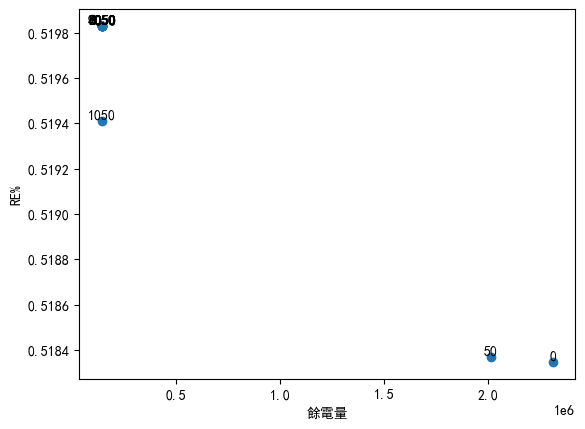

In [27]:
import matplotlib
import matplotlib.pyplot as plt

# 创建散点图
fig, ax = plt.subplots()

# 绘制散点图
ax.scatter(df_analysis['餘電量'], df_analysis['RE%'])

# 添加标记
for i, txt in enumerate(df_analysis['儲能量']):
    ax.text(df_analysis['餘電量'][i], df_analysis['RE%'][i], txt, ha='center', va='bottom')

# 這兩行是設定字型和負號的顯示方式------------------
matplotlib.rcParams['font.sans-serif']=['SimHei']
matplotlib.rcParams['axes.unicode_minus']=False

# 添加X轴和Y轴标签
ax.set_xlabel('餘電量')
ax.set_ylabel('RE%')

# 显示图形
plt.show()

In [ ]:
df_analysis.to_excel('儲能0_10000.xlsx', sheet_name='工作表1', index=False)

In [24]:
df_analysis.round(2)

,儲能量,消耗電量,購電量,RE%,餘電量,儲能,儲能充電率
0,0,41108769.0,21308518.75,0.52,2312456.87,0.00,0.00
0,50,41108769.0,21012512.41,0.52,2015507.53,296949.34,0.81
0,60,41108769.0,20957881.64,0.52,1960734.76,351722.11,0.96
0,70,41108769.0,20904722.04,0.52,1907384.66,405072.21,1.11
0,80,41108769.0,20852835.25,0.52,1855297.87,457159.00,1.25
0,90,41108769.0,20802274.58,0.52,1804537.19,507919.68,1.39


In [20]:
df_export = pd.DataFrame()

df_export['儲能量'] = [存儲量]
df_export['消耗電量'] = [data_copy2['負載load(度)'].sum()]
df_export['購電量'] = [data_copy2['總購電量(儲能)'].sum()]
總儲能 = data_copy2['儲能'].sum()
df_export['RE%'] = (df_export['購電量'] + 總儲能) / df_export['消耗電量']
df_export['餘電量'] = [data_copy2['餘電量(儲能)'].sum()]
df_export['儲能'] = [data_copy2['儲能'].sum()]
df_export

,儲能量,消耗電量,購電量,RE%,餘電量,儲能
0,90,41108769.0,1.918814e+07,0.519365,150120.320379,2.162337e+06


In [14]:
df_analysis = pd.DataFrame()

df_analysis['儲能量'] = [0]
df_analysis['消耗電量'] = [data_copy['負載load(度)'].sum()]
df_analysis['購電量'] = [data_copy['總購電量'].sum()]
df_analysis['RE%'] = df_analysis['購電量'] / df_analysis['消耗電量']
df_analysis['餘電量'] = [data_copy['餘電量'].sum()]
df_analysis['儲能'] = [data_copy['儲能'].sum()]

df_analysis

,儲能量,消耗電量,購電量,RE%,餘電量,儲能
0,0,41108769.0,2.130852e+07,0.518345,2.312457e+06,0


In [13]:
df_analysis

,儲能,消耗電量,購電量,RE%,餘電量
0,0,41108769.0,2.130852e+07,0.518345,2.312457e+06


In [45]:
data_copy2 = data_copy.copy()
data_copy2['綠電_累計'] = data_copy2['合併PVWP'].cumsum()
data_copy2['總購電量_累計'] = data_copy2['總購電量'].cumsum()
data_copy2['總購電量(儲能)_累計'] = data_copy2['總購電量(儲能)'].cumsum()
data_copy2['餘電量_累計'] = data_copy2['餘電量'].cumsum()
data_copy2['餘電量(儲能)_累計'] = data_copy2['餘電量(儲能)'].cumsum()
data_copy2['綠電_總購電量比'] = data_copy2['綠電_累計'] / data_copy2['總購電量_累計']
data_copy2['綠電_總購電量(儲能)比'] = data_copy2['綠電_累計'] / data_copy2['總購電量(儲能)_累計']

data_copy2 = data_copy2.round(2)
data_copy2.to_excel('儲能累計.xlsx', sheet_name='工作表1', index=False)

data_copy2

,時間time,負載load(度),合併PVWP,總購電量,總購電量(儲能),購電量_PV,購電量_WP,購電量(儲能)_PV,購電量(儲能)_WP,餘電量,...,餘電量_WP,餘電量(儲能)_PV,餘電量(儲能)_WP,綠電_累計,總購電量_累計,總購電量(儲能)_累計,餘電量_累計,餘電量(儲能)_累計,綠電_總購電量比,綠電_總購電量(儲能)比
0,2022-10-01 00:00:00,1005.50,343.87,343.87,343.87,0.0,343.87,0.0,343.87,0.0,...,0.0,0.0,0.0,343.87,343.87,343.87,0.00,0.00,1.00,1.00
1,2022-10-01 00:15:00,993.50,344.54,344.54,344.54,0.0,344.54,0.0,344.54,0.0,...,0.0,0.0,0.0,688.41,688.41,688.41,0.00,0.00,1.00,1.00
2,2022-10-01 00:30:00,996.00,346.22,346.22,346.22,0.0,346.22,0.0,346.22,0.0,...,0.0,0.0,0.0,1034.63,1034.63,1034.63,0.00,0.00,1.00,1.00
3,2022-10-01 00:45:00,993.50,341.34,341.34,341.34,0.0,341.34,0.0,341.34,0.0,...,0.0,0.0,0.0,1375.97,1375.97,1375.97,0.00,0.00,1.00,1.00
4,2022-10-01 01:00:00,981.50,335.06,335.06,335.06,0.0,335.06,0.0,335.06,0.0,...,0.0,0.0,0.0,1711.04,1711.04,1711.04,0.00,0.00,1.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,2023-09-30 22:45:00,1118.50,271.34,271.34,271.34,0.0,271.34,0.0,271.34,0.0,...,0.0,0.0,0.0,23619989.37,21307532.50,19187150.76,2312456.87,150120.32,1.11,1.23
35036,2023-09-30 23:00:00,1128.00,272.42,272.42,272.42,0.0,272.42,0.0,272.42,0.0,...,0.0,0.0,0.0,23620261.79,21307804.91,19187423.18,2312456.87,150120.32,1.11,1.23
35037,2023-09-30 23:15:00,1108.75,260.60,260.60,260.60,0.0,260.60,0.0,260.60,0.0,...,0.0,0.0,0.0,23620522.38,21308065.51,19187683.77,2312456.87,150120.32,1.11,1.23
35038,2023-09-30 23:30:00,1113.50,237.02,237.02,237.02,0.0,237.02,0.0,237.02,0.0,...,0.0,0.0,0.0,23620759.41,21308302.53,19187920.80,2312456.87,150120.32,1.11,1.23


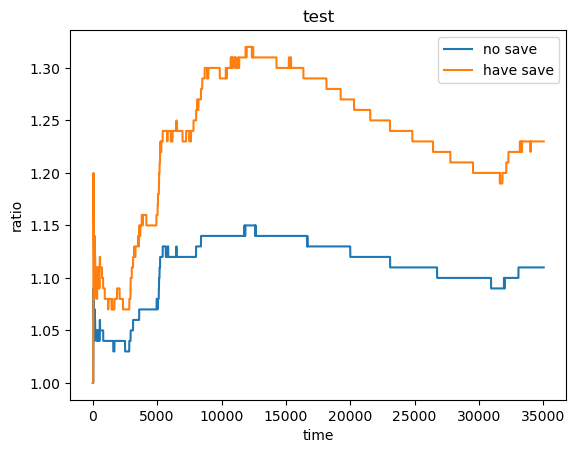

In [54]:
import matplotlib.pyplot as plt

# 假设有两组数据
z1 = data_copy2.index
z2 = data_copy2.index

x1 = data_copy2['餘電量_累計']
x2 = data_copy2['餘電量(儲能)_累計']
y1 = data_copy2['綠電_總購電量比']
y2 = data_copy2['綠電_總購電量(儲能)比']

# 创建两条线形图
plt.plot(z1, y1, label='no save')
plt.plot(z2, y2, label='have save')

# 添加标签和标题
plt.xlabel('time')
plt.ylabel('ratio')
plt.title('test')

# 添加图例
plt.legend()

# 显示图形
plt.show()


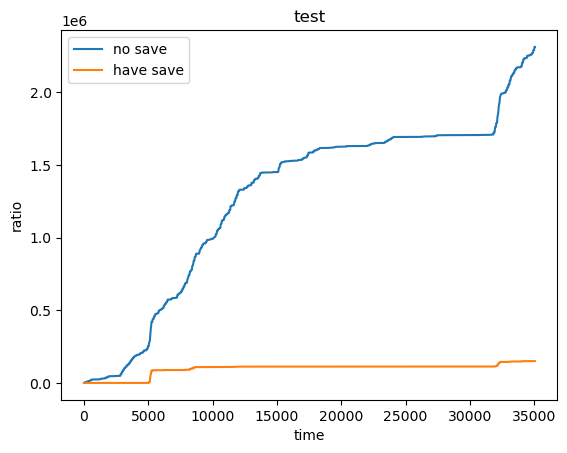

In [52]:
import matplotlib.pyplot as plt

# 假设有两组数据
z1 = data_copy2.index
z2 = data_copy2.index

x1 = data_copy2['餘電量_累計']
x2 = data_copy2['餘電量(儲能)_累計']
y1 = data_copy2['綠電_總購電量比']
y2 = data_copy2['綠電_總購電量(儲能)比']

# 创建两条线形图
# plt.plot(x1, y1, label='no save')
# plt.plot(x2, y2, label='have save')

plt.plot(z1, x1, label='no save')
plt.plot(z2, x2, label='have save')

# 添加标签和标题
plt.xlabel('time')
plt.ylabel('ratio')
plt.title('test')

# 添加图例
plt.legend()

# 显示图形
plt.show()


## 暫定最終版

In [62]:
import pandas as pd


def 讀取資料():
    data = pd.read_csv('data.csv')

    return data

def 整理資料():
    data = 讀取資料()

    data_copy = data.copy()

    # 【轉換日期】
    data_copy['時間time'] = pd.to_datetime(data_copy['時間time'])

    # 合併【綠能】
    data_copy['合併PVWP'] = data_copy['太陽能PV(度)'] + data_copy['風能WP(度)']

    # 【總購電量】&【總購電量(儲能)】----------------------------------------------------------------------------------------------------------------
    data_copy['總購電量'] = data_copy.apply(lambda row: row['負載load(度)'] if row['合併PVWP'] > row['負載load(度)'] else row['合併PVWP'], axis=1)
    data_copy['總購電量(儲能)'] = data_copy['總購電量']
    data_copy['購電量_PV'] = data_copy.apply(lambda row: row['總購電量']*(row['太陽能PV(度)']/row['合併PVWP']) if row['合併PVWP'] > row['負載load(度)'] else row['太陽能PV(度)'], axis=1)
    data_copy['購電量_WP'] = data_copy.apply(lambda row: row['總購電量']*(row['風能WP(度)']/row['合併PVWP']) if row['合併PVWP'] > row['負載load(度)'] else row['風能WP(度)'], axis=1)

    # 【餘電量】&【餘電量(儲能)】-------------------------------------------------------------------------------------------------------------------
    data_copy['餘電量'] = data_copy.apply(lambda row: row['合併PVWP'] - row['負載load(度)'] if row['合併PVWP'] > row['負載load(度)'] else 0, axis=1)
    data_copy['餘電量(儲能)'] = data_copy['餘電量']

    data_copy['餘電量_PV'] = data_copy.apply(lambda row: 0 if row['餘電量'] == 0 else row['太陽能PV(度)'] - row['購電量_PV'], axis=1)
    data_copy['餘電量_WP'] = data_copy.apply(lambda row: 0 if row['餘電量'] == 0 else row['風能WP(度)'] - row['購電量_WP'], axis=1)

    return data_copy

data_copy = 整理資料()


已存量 = 0
剩餘量 = 0
最大存儲量 = 50
data_copy['儲能'] = 0

for index, row in data_copy.iterrows():
    if 已存量 == 0:
        剩餘量 = 最大存儲量
        if row['餘電量(儲能)'] > 0:
            if row['餘電量(儲能)'] > 最大存儲量:
                已存量 = 最大存儲量
                data_copy.at[index, '儲能'] = 已存量
                剩餘量 = 最大存儲量 - 已存量
                data_copy.at[index, '餘電量(儲能)'] = row['餘電量(儲能)'] - 已存量
            else:
                已存量 = row['餘電量(儲能)']
                data_copy.at[index, '儲能'] = 已存量
                剩餘量 = 最大存儲量 - 已存量
                data_copy.at[index, '餘電量(儲能)'] = 0
    else:
        if (row['總購電量(儲能)'] - 已存量) > 0:
            data_copy.at[index, '總購電量(儲能)'] = row['總購電量'] - 已存量
            已存量 = 0
            剩餘量 = 最大存儲量

            if row['餘電量(儲能)'] > 0:
                if row['餘電量(儲能)'] >= 剩餘量:
                    已存量 = 最大存儲量
                    data_copy.at[index, '儲能'] = 已存量
                    剩餘量 = 最大存儲量 - 已存量
                    data_copy.at[index, '餘電量(儲能)'] = row['餘電量(儲能)'] - 已存量
                else:
                    已存量 = row['餘電量(儲能)']
                    data_copy.at[index, '儲能'] = 已存量
                    剩餘量 = 最大存儲量 - 已存量
                    data_copy.at[index, '餘電量(儲能)'] = 0
        else:
            data_copy.at[index, '總購電量(儲能)'] = 0
            已存量 = 0
            剩餘量 = 最大存儲量
    
    data_copy.at[index, '已存量'] = 已存量
    data_copy.at[index, '剩餘量'] = 剩餘量

data_copy['購電量(儲能)_PV'] = data_copy.apply(lambda row: row['總購電量(儲能)']*(row['太陽能PV(度)']/row['合併PVWP']) if row['合併PVWP'] > row['負載load(度)'] else row['太陽能PV(度)'], axis=1)
data_copy['購電量(儲能)_WP'] = data_copy.apply(lambda row: row['總購電量(儲能)']*(row['風能WP(度)']/row['合併PVWP']) if row['合併PVWP'] > row['負載load(度)'] else row['風能WP(度)'], axis=1)
data_copy['餘電量(儲能)_PV'] = data_copy.apply(lambda row: 0 if row['餘電量(儲能)'] == 0 else row['太陽能PV(度)'] - row['購電量(儲能)_PV'], axis=1)
data_copy['餘電量(儲能)_WP'] = data_copy.apply(lambda row: 0 if row['餘電量(儲能)'] == 0 else row['風能WP(度)'] - row['購電量(儲能)_WP'], axis=1)

columns = ['時間time', '太陽能PV(度)', '風能WP(度)', '負載load(度)', '合併PVWP', '總購電量', '總購電量(儲能)', '購電量_PV', '購電量_WP', '購電量(儲能)_PV', '購電量(儲能)_WP', '餘電量', '餘電量(儲能)', '餘電量_PV', '餘電量_WP', '餘電量(儲能)_PV', '餘電量(儲能)_WP', '儲能', '已存量', '剩餘量']
# columns = ['時間time', '負載load(度)', '合併PVWP', '總購電量', '總購電量(儲能)', '購電量_PV', '購電量_WP', '購電量(儲能)_PV', '購電量(儲能)_WP', '餘電量', '餘電量(儲能)', '餘電量_PV', '餘電量_WP', '餘電量(儲能)_PV', '餘電量(儲能)_WP']

data_copy = data_copy[columns]


data_copy.to_excel('儲能50.xlsx', sheet_name='工作表1', index=False)

data_copy

,時間time,太陽能PV(度),風能WP(度),負載load(度),合併PVWP,總購電量,總購電量(儲能),購電量_PV,購電量_WP,購電量(儲能)_PV,購電量(儲能)_WP,餘電量,餘電量(儲能),餘電量_PV,餘電量_WP,餘電量(儲能)_PV,餘電量(儲能)_WP,儲能,已存量,剩餘量
0,2022-10-01 00:00:00,0.0,343.871142,1005.50,343.871142,343.871142,343.871142,0.0,343.871142,0.0,343.871142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0
1,2022-10-01 00:15:00,0.0,344.542670,993.50,344.542670,344.542670,344.542670,0.0,344.542670,0.0,344.542670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0
2,2022-10-01 00:30:00,0.0,346.219584,996.00,346.219584,346.219584,346.219584,0.0,346.219584,0.0,346.219584,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0
3,2022-10-01 00:45:00,0.0,341.339229,993.50,341.339229,341.339229,341.339229,0.0,341.339229,0.0,341.339229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0
4,2022-10-01 01:00:00,0.0,335.064191,981.50,335.064191,335.064191,335.064191,0.0,335.064191,0.0,335.064191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,2023-09-30 22:45:00,0.0,271.342852,1118.50,271.342852,271.342852,271.342852,0.0,271.342852,0.0,271.342852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0
35036,2023-09-30 23:00:00,0.0,272.416376,1128.00,272.416376,272.416376,272.416376,0.0,272.416376,0.0,272.416376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0
35037,2023-09-30 23:15:00,0.0,260.597183,1108.75,260.597183,260.597183,260.597183,0.0,260.597183,0.0,260.597183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0
35038,2023-09-30 23:30:00,0.0,237.022211,1113.50,237.022211,237.022211,237.022211,0.0,237.022211,0.0,237.022211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0


# backup

In [ ]:
import pandas as pd


def 讀取資料():
    data = pd.read_csv('data.csv')

    return data

def 整理資料():
    data = 讀取資料()

    data_copy = data.copy()

    # 【轉換日期】
    data_copy['時間time'] = pd.to_datetime(data_copy['時間time'])

    # 合併【綠能】
    data_copy['合併PVWP'] = data_copy['太陽能PV(度)'] + data_copy['風能WP(度)']

    # 【總購電量】&【總購電量(儲能)】----------------------------------------------------------------------------------------------------------------
    data_copy['總購電量'] = data_copy.apply(lambda row: row['負載load(度)'] if row['合併PVWP'] > row['負載load(度)'] else row['合併PVWP'], axis=1)
    data_copy['總購電量(儲能)'] = data_copy['總購電量']
    data_copy['購電量_PV'] = data_copy.apply(lambda row: row['總購電量']*(row['太陽能PV(度)']/row['合併PVWP']) if row['合併PVWP'] > row['負載load(度)'] else row['太陽能PV(度)'], axis=1)
    data_copy['購電量_WP'] = data_copy.apply(lambda row: row['總購電量']*(row['風能WP(度)']/row['合併PVWP']) if row['合併PVWP'] > row['負載load(度)'] else row['風能WP(度)'], axis=1)

    # 【餘電量】&【餘電量(儲能)】-------------------------------------------------------------------------------------------------------------------
    data_copy['餘電量'] = data_copy.apply(lambda row: row['合併PVWP'] - row['負載load(度)'] if row['合併PVWP'] > row['負載load(度)'] else 0, axis=1)
    data_copy['餘電量(儲能)'] = data_copy['餘電量']

    data_copy['餘電量_PV'] = data_copy.apply(lambda row: 0 if row['餘電量'] == 0 else row['太陽能PV(度)'] - row['購電量_PV'], axis=1)
    data_copy['餘電量_WP'] = data_copy.apply(lambda row: 0 if row['餘電量'] == 0 else row['風能WP(度)'] - row['購電量_WP'], axis=1)

    return data_copy

data_copy = 整理資料()


已存量 = 0
剩餘量 = 0
最大存儲量 = 1000
data_copy['儲能'] = 0

for index, row in data_copy.iterrows():
    if 已存量 == 0:
        剩餘量 = 最大存儲量
        if row['餘電量(儲能)'] > 0:
            if row['餘電量(儲能)'] > 最大存儲量:
                已存量 = 最大存儲量
                data_copy.at[index, '儲能'] = 已存量
                剩餘量 = 最大存儲量 - 已存量
                data_copy.at[index, '餘電量(儲能)'] = row['餘電量(儲能)'] - 已存量
            else:
                已存量 = row['餘電量(儲能)']
                data_copy.at[index, '儲能'] = 已存量
                剩餘量 = 最大存儲量 - 已存量
                data_copy.at[index, '餘電量(儲能)'] = 0
    else:
        if (row['總購電量(儲能)'] - 已存量) > 0:
            data_copy.at[index, '總購電量(儲能)'] = row['總購電量'] - 已存量
            已存量 = 0
            剩餘量 = 最大存儲量

            if row['餘電量(儲能)'] > 0:
                if row['餘電量(儲能)'] >= 剩餘量:
                    已存量 = 最大存儲量
                    data_copy.at[index, '儲能'] = 已存量
                    剩餘量 = 最大存儲量 - 已存量
                    data_copy.at[index, '餘電量(儲能)'] = row['餘電量(儲能)'] - 已存量
                else:
                    已存量 = row['餘電量(儲能)']
                    data_copy.at[index, '儲能'] = 已存量
                    剩餘量 = 最大存儲量 - 已存量
                    data_copy.at[index, '餘電量(儲能)'] = 0
        else:
            data_copy.at[index, '總購電量(儲能)'] = 0
            已存量 = 0
            剩餘量 = 最大存儲量
    
    data_copy.at[index, '已存量'] = 已存量
    data_copy.at[index, '剩餘量'] = 剩餘量

data_copy['購電量(儲能)_PV'] = data_copy.apply(lambda row: row['總購電量(儲能)']*(row['太陽能PV(度)']/row['合併PVWP']) if row['合併PVWP'] > row['負載load(度)'] else row['太陽能PV(度)'], axis=1)
data_copy['購電量(儲能)_WP'] = data_copy.apply(lambda row: row['總購電量(儲能)']*(row['風能WP(度)']/row['合併PVWP']) if row['合併PVWP'] > row['負載load(度)'] else row['風能WP(度)'], axis=1)
data_copy['餘電量(儲能)_PV'] = data_copy.apply(lambda row: 0 if row['餘電量(儲能)'] == 0 else row['太陽能PV(度)'] - row['購電量(儲能)_PV'], axis=1)
data_copy['餘電量(儲能)_WP'] = data_copy.apply(lambda row: 0 if row['餘電量(儲能)'] == 0 else row['風能WP(度)'] - row['購電量(儲能)_WP'], axis=1)

columns = ['時間time', '太陽能PV(度)', '風能WP(度)', '負載load(度)', '合併PVWP', '總購電量', '總購電量(儲能)', '購電量_PV', '購電量_WP', '購電量(儲能)_PV', '購電量(儲能)_WP', '餘電量', '餘電量(儲能)', '餘電量_PV', '餘電量_WP', '餘電量(儲能)_PV', '餘電量(儲能)_WP', '儲能', '已存量', '剩餘量']
data_copy = data_copy[columns]


data_copy.to_excel('儲能2.xlsx', sheet_name='工作表1', index=False)

data_copy